In [175]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, Normalizer
from sklearn.metrics import pairwise_distances
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.base import TransformerMixin

import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import os, sys, email,re
from sklearn.metrics import silhouette_score, silhouette_samples



[nltk_data] Downloading package stopwords to /home/ki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [176]:
df = pd.read_csv('../projectfinder.csv')
df.dropna(axis=0, inplace=True)
df.head()
#df.describe()

,skill_summary,title,description
0,"tableau, visualisierung",Business Intelligence Analyst (m/w) - Tableau ...,Business Intelligence Analyst (m/w) - Tableau ...
1,", implementierung, java, ms sql, camel, apache...",Developer - Talend ESB oder Apache Camel (m/w)...,"Konzeption, Customizing sowie Softwareanpassun..."
2,", windows, clients, ios, mobile devices, mobil...",IT-Mitarbeiter (m/w) 1st / 2nd Level Support /...,"Als Mitglied eines kleinen, dynamischen Teams ..."
3,"dynamics ax 2009, dynamics crm 4.0, dynamics a...",Consultant für Microsoft Dynamics CRM (m/w),Über unseren Kunden: \n \n Unser Kunde ist e...
4,"hibernate, java, deutsch, oracle 11g, oracle 1...",Java Senior Developer - Backend (f/m),Über unseren Kunden: \n \n Unser Kunde ist e...


In [177]:
#split features
title = df['title']
description = df['description']
skill = df['skill_summary']

In [178]:
# load nltk's German stopwords'
with open('../stopwords-de.txt', 'r') as f:
    stopwords_germ = f.read().splitlines()

stopwords_eng = nltk.corpus.stopwords.words('english')
extra = ['bewerben', 'direkt', 'melden', 'www', 'contactor', 'erfahrung', 'kenntnisse',
'contractor','https','de','impressum','munchen','frankfurt']
stopwords = stopwords_germ + stopwords_eng + extra


In [179]:
# load nltk's SnowballStemmer
from nltk.stem.snowball import SnowballStemmer
stemmer_eng = SnowballStemmer("english")
stemmer_germ = SnowballStemmer("german")

In [180]:
def clean_and_stem(word):
    clean_word = str(word).replace('[','').replace(']','').replace("'", "")
    #stemming lowers also
    eng_stem = stemmer_eng.stem(clean_word)
    germ_stem= stemmer_germ.stem(eng_stem)
    return germ_stem


In [181]:
def get_optimal_data(df):
    #split features
    col = [col for col in df.columns]
    combined = df[col[0]] + ' '  + df[col[1]] + ' '  + df[col[2]]
    combined_tolist = [item.split() for item in combined]
    combined_cleaned = [clean_and_stem(word) for word in combined_tolist]
    return combined_cleaned

In [182]:
vectorizer = CountVectorizer(stop_words=stopwords,ngram_range=(1, 1))
tfidf = TfidfVectorizer(stop_words=stopwords,ngram_range=(1, 2))

#X = vectorizer.fit_transform(chi)
X = tfidf.fit_transform(get_optimal_data(df))
X.shape


/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['wahr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(5360, 261347)

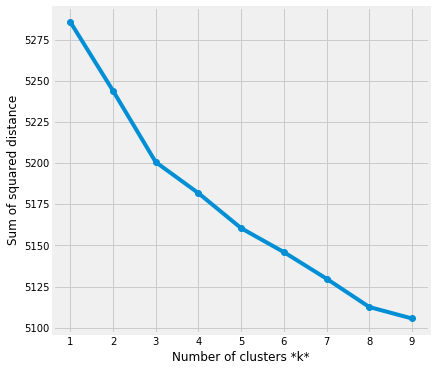

In [124]:
#Finding optimal number of clusters using Elbow
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters')
plt.ylabel('Sum of squared distance');

In [199]:
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=2)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=3, n_init=2, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [200]:
from sklearn.decomposition import TruncatedSVD
#dimensionality reduction
SVD = TruncatedSVD(n_components=2).fit_transform(X)
#cluster center
#centers = pca1.transform(model.cluster_centers_)
#model labels
labels = model.labels_.tolist()

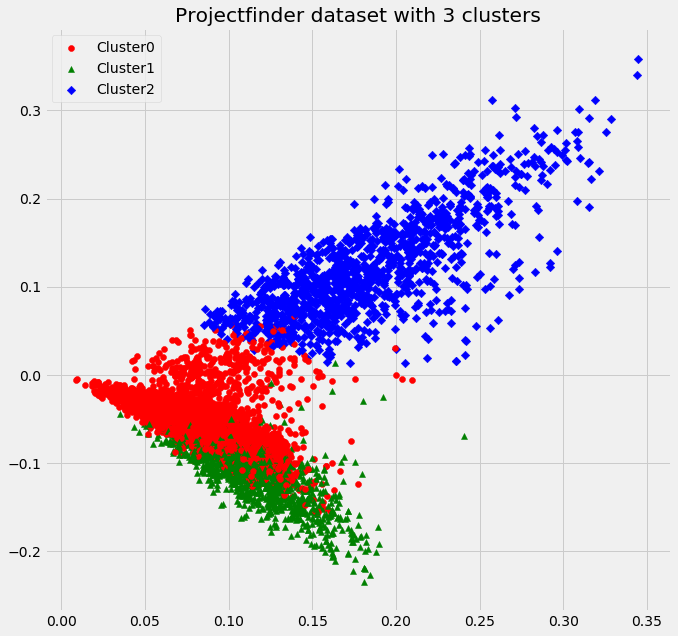

In [208]:
import pylab as pl
pl.figure(figsize=(10, 10))
for i in range(0, SVD.shape[0]):
    if model.labels_[i] == 0:
        c0 = pl.scatter(SVD[i,0],SVD[i,1],c='r', marker='o')
    elif model.labels_[i] == 1:
        c1 = pl.scatter(SVD[i,0],SVD[i,1],c='g', marker='^')
    elif model.labels_[i] == 2:
        c2 = pl.scatter(SVD[i,0],SVD[i,1],c='b', marker='D')
#plt.scatter(centers[:,0], centers[:,1], marker='x', s=300, linewidths=3, c='y') 
pl.legend([c0, c1, c2], ['Cluster0', 'Cluster1','Cluster2'])
pl.title('Projectfinder dataset with 3 clusters')
pl.savefig('projectfinder_cluster.png', bbox_inches='tight')
pl.show()

In [206]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
order_centroids
#terms


array([[254895, 156631, 220113, ...,  92407,  92408, 130673],
       [122064,  78931, 213500, ..., 149414, 149413, 261346],
       [196892,   8229,  92290, ..., 162727, 162724, 130673]])

In [207]:
for i in range(true_k):
    print()
    print(f'Cluster {i}')
    
    for ind in order_centroids[i, :10]:
        print(terms[ind])


Cluster 0
windows
net
support
sql
data
kunden
server
business
oracle
ms

Cluster 1
java
entwickler
spring
frontend
angular
java entwickler
javascript
js
entwicklung
developer

Cluster 2
sap
abap
fi
berater
hana
sd
sap fi
co
mm
pp


In [121]:

def evaluate_kmeans(X, model, metric='euclidean'):
    """ Evaluate a K-Means model that has been trained on X using the
     Silhouette score.

    Args:
        X: the TF-IDF matrix where each line represents a document and each
           column represents a word, typically obtained by running
           transform_text() from the TP2.
        model: the KMeans model trained on X.
    Returns:
        A double that corresponds to the Silhouette score of the model.
    """
    return silhouette_score(X, model.labels_)

In [122]:
evaluate_kmeans(X, model)

0.009520793678100435

In [210]:
#Projects Tagging
df['label'] = labels
df.head()

,skill_summary,title,description,label
0,"tableau, visualisierung",Business Intelligence Analyst (m/w) - Tableau ...,Business Intelligence Analyst (m/w) - Tableau ...,0
1,", implementierung, java, ms sql, camel, apache...",Developer - Talend ESB oder Apache Camel (m/w)...,"Konzeption, Customizing sowie Softwareanpassun...",0
2,", windows, clients, ios, mobile devices, mobil...",IT-Mitarbeiter (m/w) 1st / 2nd Level Support /...,"Als Mitglied eines kleinen, dynamischen Teams ...",0
3,"dynamics ax 2009, dynamics crm 4.0, dynamics a...",Consultant für Microsoft Dynamics CRM (m/w),Über unseren Kunden: \n \n Unser Kunde ist e...,0
4,"hibernate, java, deutsch, oracle 11g, oracle 1...",Java Senior Developer - Backend (f/m),Über unseren Kunden: \n \n Unser Kunde ist e...,1


# Trial and Errors

In [35]:
title_pipe = make_pipeline(
       DataFrameColumnExtracter('title'), 
       CountVectorizer(ngram_range=(1, 2), analyzer='word', stop_words=stopwords)
)

desc_pipe = make_pipeline(
       DataFrameColumnExtracter('description'), 
       CountVectorizer(ngram_range=(1, 2), analyzer='word', stop_words=stopwords)
)

skill_pipe = make_pipeline(
       DataFrameColumnExtracter('skill_summary'), 
       CountVectorizer(ngram_range=(1, 2), analyzer='word', stop_words=stopwords)
)


In [48]:
 sparse_matrix_of_counts = feature_union.fit_transform(df)
